# OpenPoseを使ってパラメータ取得

## モジュール読み込み

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import os
import sys
sys.path.append("../")
from utils import variables, datasets

In [26]:
from openpose.openpose import OpenPose

## 1枚の静止画に対してパラメータを取得

In [27]:
cap = cv2.VideoCapture("/media/nvidia/ST_USB32G/AbemaTV_tournament_takami_vs_kubo_movie.mp4")

In [5]:
params = variables.params

In [6]:
openpose = OpenPose(params)

|parts|||||
|---|||||
|0: "Nose"|1: "Neck"|2: "RShoulder"|3: "RElbow"|4: "RWrist",|5: "LShoulder"|
|6: "LElbow"|7: "LWrist"|8: "MidHip"|9: "RHip"|10:"RKnee"|
|11:"RAnkle"|12:"LHip"|13:"LKnee"|14:"LAnkle"|15:"REye"|
|16:"LEye"|17:"REar"|18:"LEar"|19:"LBigToe"|20:"LSmallToe"|
|21:"LHeel"|22:"RBigToe"|23:"RSmallToe"|24:"RHeel"|25:"Background"|

今回取得するのはNose,Neck,RShoulder,RElbow, LShoulder, LElbow, REye, LEye

In [7]:
keypoints_dict = variables.keypoints_dict
get_parts_list = ["Nose","Neck","RShoulder","RElbow", "LShoulder", "LElbow", "REye", "LEye"]

[[1.0721460e+03 2.4336037e+02 9.4378483e-01]
 [1.1034240e+03 2.5914981e+02 9.2316723e-01]
 [1.0446980e+03 2.5718683e+02 8.7069911e-01]
 [1.0408335e+03 3.4336847e+02 6.5832198e-01]
 [1.1602942e+03 2.6498932e+02 7.6922184e-01]
 [1.1602981e+03 3.6683835e+02 5.4548156e-01]
 [1.0877198e+03 2.2972812e+02 9.0505171e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[2.3954936e+02 5.3922052e+02 9.3849045e-01]
 [1.9451604e+02 5.5291809e+02 8.5345590e-01]
 [1.4932974e+02 5.5294507e+02 7.6083362e-01]
 [1.5918600e+02 6.2352521e+02 7.5406176e-01]
 [2.4344595e+02 5.4903027e+02 6.8064684e-01]
 [2.3756001e+02 6.2547296e+02 4.9703506e-01]
 [2.5124666e+02 5.2563196e+02 8.4191406e-01]
 [1.9844525e+02 5.0396405e+02 8.2848746e-01]]


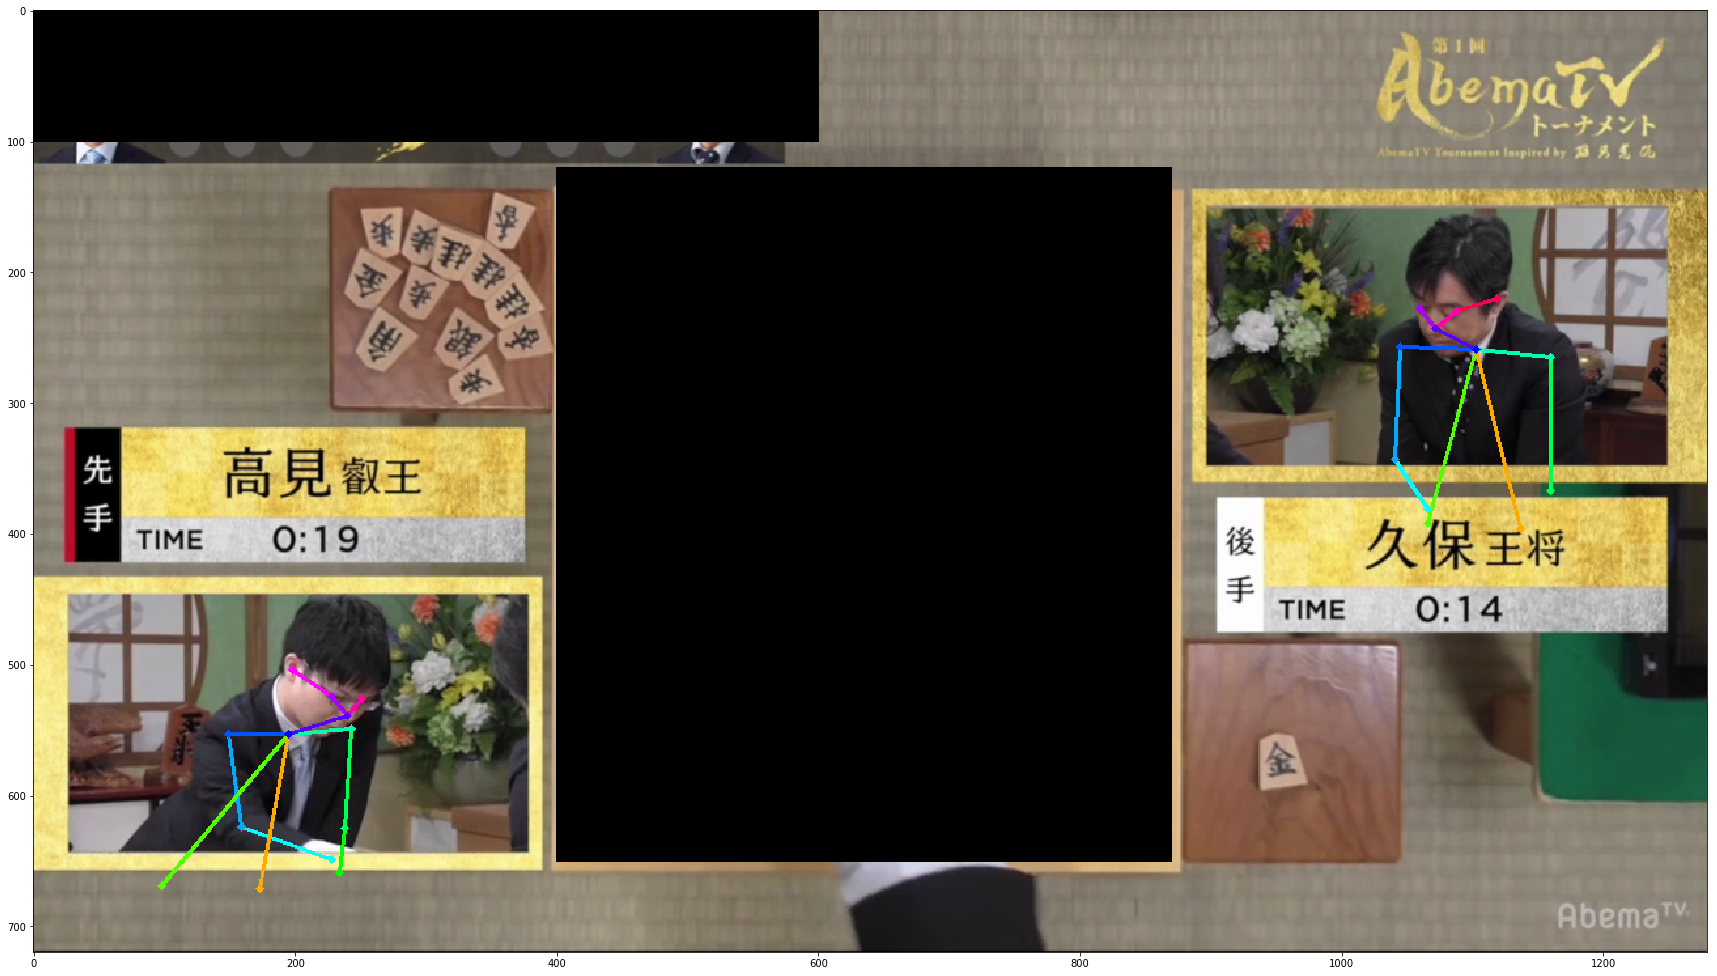

In [8]:
plt.figure(figsize=(30,18))

cap.set(cv2.CAP_PROP_POS_FRAMES, 74670)
_, frame = cap.read()

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.rectangle(img, (0, 0), (600, 100), (0, 0, 0), -1)
cv2.rectangle(img, (400, 120), (870, 650), (0, 0, 0), -1)

keypoints, output_image = openpose.forward(img, True)

for player_key in keypoints:
    print(player_key[[keypoints_dict[i] for i in get_parts_list]])

plt.imshow(output_image)

## フレームごとにサンプリングしOpenPoseを適用

In [28]:
# 1秒ごとに計算させる
n_frame = 3
player1, player2 = [], []
output_path = "/media/nvidia/ST_SD16G/Research/output/"

frame_all = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = [_ for _ in range(frame_all) if _%n_frame == 0][:300]

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (cap.read()[1].shape[1], cap.read()[1].shape[0]))

for idx in tqdm(frame_idx):  
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    _, frame = cap.read()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (0, 0), (600, 100), (0, 0, 0), -1)
    cv2.rectangle(img, (400, 120), (870, 650), (0, 0, 0), -1)

    keypoints, output_image = openpose.forward(img, True)
    
    try:
        player1.append(keypoints[0][[keypoints_dict[i] for i in get_parts_list]].ravel())
        player2.append(keypoints[1][[keypoints_dict[i] for i in get_parts_list]].ravel())
    except:
        print("player1,2 not detection")
        
    out.write(cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

    #cv2.imwrite(os.path.join(output_path, "img/{0:06d}.png".format(idx)), cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

In [29]:
cap.release()
out.release()

In [24]:
output_path = "/media/nvidia/ST_SD16G/Research/data/"

In [26]:
p1_df = pd.DataFrame(np.array(player1), \
        columns=["{}{}".format(parts, point) for parts in get_parts_list for point in ["_x", "_y", "_z"]])
p2_df = pd.DataFrame(np.array(player2), \
        columns=["{}{}".format(parts, point) for parts in get_parts_list for point in ["_x", "_y", "_z"]])

p1_df.to_csv(os.path.join(output_path, "player1_features_frame{}_v2.csv".format(n_frame)))
p2_df.to_csv(os.path.join(output_path, "player2_features_frame{}_v2.csv".format(n_frame)))

In [27]:
p1_df.head()

,Nose_x,Nose_y,Nose_z,Neck_x,Neck_y,Neck_z,RShoulder_x,RShoulder_y,RShoulder_z,RElbow_x,...,LShoulder_z,LElbow_x,LElbow_y,LElbow_z,REye_x,REye_y,REye_z,LEye_x,LEye_y,LEye_z
0,1074.120117,227.733719,0.976848,1099.547119,276.720032,0.863911,1042.826172,274.864227,0.898137,1029.007080,...,0.829763,1150.425415,368.872162,0.552189,1087.842407,214.080902,0.967030,0.0,0.0,0.0
1,1074.071777,227.723923,0.984512,1097.595093,276.715973,0.862189,1042.769775,274.879547,0.907020,1027.141602,...,0.830836,1150.471069,368.770081,0.556024,1087.781616,214.069870,0.959511,0.0,0.0,0.0
2,1074.052612,227.736115,0.989574,1097.570312,276.698975,0.868382,1042.761230,274.881134,0.903304,1027.173706,...,0.834562,1150.553711,366.861176,0.564301,1087.765625,214.088974,0.952181,0.0,0.0,0.0
3,1074.047729,227.750763,0.988936,1095.673706,276.697235,0.870513,1042.740845,274.878571,0.907569,1027.181885,...,0.831546,1152.396973,366.864258,0.567580,1087.755371,214.110519,0.944013,0.0,0.0,0.0
4,1074.021240,227.759781,0.987154,1095.675781,276.715546,0.864598,1042.733154,274.888123,0.907662,1027.162231,...,0.828406,1150.543091,366.916168,0.563587,1087.735718,214.104477,0.939467,0.0,0.0,0.0


In [28]:
p1_df.shape

(12446, 24)

In [11]:
df = pd.read_csv(os.path.join(output_path, "player2_features_v2.csv"), index_col=0)

In [12]:
df

,Nose_x,Nose_y,Nose_z,Neck_x,Neck_y,Neck_z,RShoulder_x,RShoulder_y,RShoulder_z,RElbow_x,...,LShoulder_z,LElbow_x,LElbow_y,LElbow_z,REye_x,REye_y,REye_z,LEye_x,LEye_y,LEye_z
0,266.97705,568.68360,0.839319,227.75848,580.38500,0.844021,186.590120,580.41420,0.761279,196.438700,...,0.824966,261.03073,648.96540,0.577690,274.73700,556.94495,0.811642,235.608890,541.15010,0.875915
1,264.95007,568.59576,0.823604,227.79090,578.44430,0.847256,186.631180,580.38850,0.761053,194.468230,...,0.831820,261.05475,648.90860,0.569793,272.87842,556.88745,0.865443,233.627100,539.33844,0.884840
2,257.21927,562.79500,0.854362,227.76057,576.48975,0.848225,186.635070,576.48944,0.766324,153.336900,...,0.834302,259.11642,647.01550,0.559079,270.79880,554.97970,0.857759,227.858780,537.31180,0.923341
3,263.02370,570.49450,0.826759,225.74763,582.37036,0.849346,182.758090,574.59210,0.791813,165.143920,...,0.776999,259.11850,647.03625,0.510867,272.79580,558.86150,0.744068,233.669800,539.25793,0.879220
4,270.83853,570.58070,0.869557,227.67761,584.30945,0.852729,188.571660,582.33636,0.757144,186.608300,...,0.758197,259.18304,648.97910,0.482577,274.79410,558.86600,0.658237,239.500800,541.25690,0.866492
5,257.06770,568.68036,0.850298,223.81396,586.33580,0.858249,178.792450,594.11975,0.787227,165.009950,...,0.750002,257.21298,650.96540,0.470040,263.06534,556.89290,0.803226,225.865980,541.27660,0.914186
6,241.39203,572.57280,0.915550,221.85124,580.40130,0.808145,176.799880,588.24040,0.837971,165.070880,...,0.869760,257.22684,649.00280,0.678710,245.44278,558.85570,0.814346,210.072950,551.01904,0.788916
7,241.45828,578.42610,0.799537,221.88646,582.38810,0.815108,176.809710,590.17720,0.814277,165.084050,...,0.851097,259.02356,643.07390,0.665323,245.43515,568.59344,0.741365,212.039380,556.91290,0.756328
8,243.43748,586.20210,0.792093,219.93079,584.26196,0.783192,176.787250,590.22490,0.796756,163.162200,...,0.770707,257.19473,637.27420,0.619900,251.25371,572.54285,0.559829,216.036450,560.86260,0.622150
9,243.35889,588.29170,0.586065,221.84866,586.33570,0.853871,174.893000,596.10846,0.782110,165.111820,...,0.728302,257.22560,648.94540,0.522035,247.37372,580.39355,0.365062,216.013720,568.64545,0.524627
